### **11-layers Mnist CNN 99.09% accuracy**

**Piyawud Koonmanee 63110119**\
Date of Submission: 8-Mar-2022\
Runtime: 
- ~23 seconds using Nvidia T4 (from Google Colab)
- ~4 minute 32 seconds using Intel Core i5-8300H

In [124]:
%reset # clear the variables
import tensorflow as tf
import numpy as np
import random

from tensorflow.keras import Model, layers, Sequential
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# setup the random state (seed) to obtain reproducible results
np.random.seed(63110119) 
random.seed(63110119)
tf.random.set_seed(63110119)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [125]:
# prepare dataset

# MNIST dataset parameters
num_classes = 10 # total classes (0-9 digits)
num_features = 784 # data features (img shape: 28 X 28 = 784)

# import and load MNIST data, split between test and train datasets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# convert pixel values to float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# normalize image pixcel values from [0, 255] to [0, 1]
x_train, x_test = x_train/255.0 , x_test/255.0

# set gray scale color channel (to make it work for Conv2D since it needs the dimenstion to be 4)
x_train, x_test = np.expand_dims(x_train, axis=-1), np.expand_dims(x_test, axis=-1)

# check the shape of MNIST data
print('MNIST Dataset Shapes:')
print('x_train: ' + str(x_train.shape))
print('y_train: ' + str(y_train.shape))
print('x_test: ' + str(x_test.shape))
print('y_test: ' + str(y_test.shape))

MNIST Dataset Shapes:
x_train: (60000, 28, 28, 1)
y_train: (60000,)
x_test: (10000, 28, 28, 1)
y_test: (10000,)


In [126]:
# training parameters   
learning_rate = 0.1
training_epochs = 2000
batch_size = 256
display_step = 100

In [127]:
# network parameters
n_hidden_1 = 32
n_hidden_2 = 64 
n_hidden_3 = 128

In [128]:
# # use tf.data API to shuffle and batch data
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [129]:
# create MNIST architecture
class ConvNeuralNet(Model):
    
    # set layers
    def __init__(self):
        super(ConvNeuralNet, self).__init__()
        
        # using Sequential() to avoid passing many variables in forward pass (call function)
        # easier to edit or change the layer
        self.model = Sequential()

        # first CNN layer
        self.model.add(layers.Conv2D(n_hidden_1, (3,3), activation=tf.nn.relu, kernel_initializer='he_uniform')) # initialize the weight matrix randomly using uniform distribution method (he_uniform)
        self.model.add(layers.MaxPool2D((2,2))) # downsample data to half for speed
        self.model.add(layers.Dropout(0.5)) # using dropout to make the model less rely on weight (prevent overfit)
        
        # second CNN layer
        self.model.add(layers.Conv2D(n_hidden_2, (3,3), activation=tf.nn.relu, kernel_initializer='he_uniform'))
        self.model.add(layers.MaxPool2D((2,2)))
        self.model.add(layers.Dropout(0.5))

        # third CNN layer
        self.model.add(layers.Conv2D(n_hidden_3, (3,3), activation=tf.nn.relu, kernel_initializer='he_uniform'))
        self.model.add(layers.Dropout(0.5))

        self.model.add(layers.Flatten())  # flatten features in to a single column
        self.model.add(layers.Dense(units = 64, activation=tf.nn.relu))

        # output layer
        self.model.add(layers.Dense(units = num_classes)) # combine to 10 classes

    # set forward pass
    def call(self, x, is_training = False):    
        
        x = self.model(x)

        if not is_training:
            
            # tf cross entropy expect logits without softmax, so only
            # apply softmax when not training.
            tf.nn.softmax(x)
        return x

In [130]:
# build Convolutional neural network model
cnn = ConvNeuralNet()

In [131]:
# initialize variables with Xavier uniform
shape = (num_features, num_classes)
initializer = tf.initializers.GlorotUniform()
trainable_variables = tf.Variable(initializer(shape = shape))

In [132]:
# Cross-Entropy loss
# note that this will apply 'softmax' to the logits
def cross_entropy_loss(x, y):
    
    # convert labels to int 64 for tf cross-entropy function
    y = tf.cast(y, tf.int64)
    
    # apply softmax to logits and compute cross-entropy
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y, logits = x)
    
    # average loss across the batch
    return tf.reduce_mean(loss)

In [133]:
# accuracy metric
def accuracy(y_pred, y_true):
    
    # predicted class is the index of highest score in prediction vector (i.e. argmax)
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

In [134]:
# Stochastic gradient descent optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate)

# set up an optimization (forward propagation and backpropagation) process 
def run_optimization(x, y):

    # wrap computation inside a GradientTape for automatic differentiation
    with tf.GradientTape() as g:
        
        # forward pass
        pred = cnn(x, is_training = True)
        
        # compute loss
        loss = cross_entropy_loss(pred, y)
        
    # variables to update, i.e. trainable variables
    trainable_variables = cnn.trainable_variables

    # compute gradients
    gradients = g.gradient(loss, trainable_variables)
    
    # apply the gradients to update 𝜃 and 𝜃_0  
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [135]:
# run training for the given number of steps
for step, (batch_x, batch_y) in enumerate(train_data.take(training_epochs), 1):
    
    # run the optimization process to update 𝜃 and 𝜃_0 values
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = cnn(batch_x, is_training = True)
        loss = cross_entropy_loss(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))
        
# test the proposed model on validation set
pred = cnn(x_test, is_training = False)
print("Test Accuracy: %f" % accuracy(pred, y_test))

step: 100, loss: 0.177339, accuracy: 0.941406
step: 200, loss: 0.151166, accuracy: 0.957031
step: 300, loss: 0.049901, accuracy: 0.984375
step: 400, loss: 0.062253, accuracy: 0.984375
step: 500, loss: 0.101288, accuracy: 0.972656
step: 600, loss: 0.053857, accuracy: 0.988281
step: 700, loss: 0.015418, accuracy: 1.000000
step: 800, loss: 0.012964, accuracy: 1.000000
step: 900, loss: 0.061007, accuracy: 0.984375
step: 1000, loss: 0.012826, accuracy: 1.000000
step: 1100, loss: 0.005304, accuracy: 1.000000
step: 1200, loss: 0.018710, accuracy: 0.996094
step: 1300, loss: 0.009381, accuracy: 1.000000
step: 1400, loss: 0.019845, accuracy: 0.996094
step: 1500, loss: 0.009746, accuracy: 1.000000
step: 1600, loss: 0.024504, accuracy: 0.996094
step: 1700, loss: 0.018120, accuracy: 0.996094
step: 1800, loss: 0.007732, accuracy: 1.000000
step: 1900, loss: 0.010350, accuracy: 1.000000
step: 2000, loss: 0.013916, accuracy: 0.992188
Test Accuracy: 0.990900


Prediction: 9


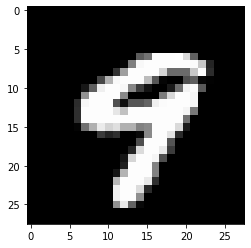

In [136]:
# testing out the prediction
img = x_test[random.randint(0, 10000)]
plt.imshow(np.squeeze(img), cmap='gray')

img = img.reshape(1,img.shape[0],img.shape[1],img.shape[2])
pred_val = cnn.predict(img)
print("Prediction:",np.argmax(pred_val))

In [137]:
# model summary: 11 layers
cnn.model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 13, 13, 32)        0         
                                                                 
 conv2d_27 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 dropout_25 (Dropout)        (None, 5, 5, 64)         